In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c spaceship-titanic

100% 299k/299k [00:00<00:00, 906kB/s]
100% 299k/299k [00:00<00:00, 905kB/s]


In [ ]:
!unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


##Understanding and cleaning the Data

In [ ]:
import pandas as pd

df = pd.read_csv("train.csv")

In [ ]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')

##Since the Name feature is not that helpful, replace it with Last Name and also create a new feature PG from the PassengerId

In [ ]:
df["Name"] = df.Name.str.split().str[-1]
df['PG'] = df.PassengerId.str.split('_').str[0]

In [ ]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PG
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Ofracculy,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Vines,True,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Susent,False,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Susent,False,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Santantines,True,0004


# Fix Missing Data

In [ ]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
PG                0
dtype: int64



##1.   HomePlanet



###Check whether same PG has same HomePlanet or not

In [ ]:
hpgrouped = df.groupby('PG')
(hpgrouped.HomePlanet.nunique()<=1).all()

True

## Use passenger group to fill missing HomePlanet data since same PG has same HomePlanet

In [ ]:
def fill(x):
  if not pd.isnull(x.HomePlanet):
    return x.HomePlanet
  v = df.HomePlanet[df.PG==x.PG].dropna().mode()
  if v.shape[0]>0:
    return v[0]
  return x.HomePlanet

df.HomePlanet = df.apply(fill, axis=1)
df.HomePlanet.isna().sum()

111

###Check whether same Last Name has same HomePlanet or not

In [ ]:
hpgrouped = df.groupby('Name')
(hpgrouped.HomePlanet.nunique()<=1).all()

True

###Use Family Name to fill missing HomePlanet data since passengers having same name will be from same HomePlanet.

In [ ]:
def fill(x):
  if not pd.isnull(x.HomePlanet):
    return x.HomePlanet
  v = df.HomePlanet[df.Name==x.Name].dropna().mode()
  if v.shape[0]>0:
    return v[0]
  return x.HomePlanet

df.HomePlanet = df.apply(fill, axis=1)
df.HomePlanet.isna().sum()

12

###For the rest empty values, use probability to fill

In [ ]:
import random
probs = df.HomePlanet.value_counts()/ df.HomePlanet.count()
df.HomePlanet = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.HomePlanet) else x.HomePlanet, axis=1)


##2.   CryoSleep



In [ ]:
df.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
PG                0
dtype: int64

###If any of RoomService, ShoppingMall, FoodCourt, Spa or VRDeck is greater than zero then set CryoSleep to false

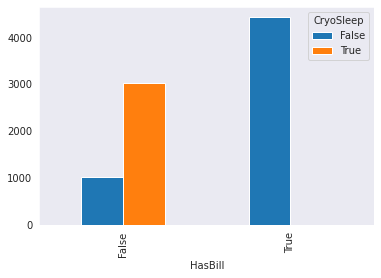

In [ ]:
hasBill = (df.RoomService + df.ShoppingMall + df.FoodCourt + df.Spa + df.VRDeck)>0
tb=pd.crosstab(hasBill, df.CryoSleep)
tb.plot(kind='bar', xlabel='HasBill')

In [ ]:
df.CryoSleep = df.apply(lambda x: False if pd.isnull(x.CryoSleep) and any((x.VRDeck, x.ShoppingMall, x.RoomService, x.FoodCourt, x.Spa))>0 else x.CryoSleep, axis=1)

### Fill based on whether the destination is TRAPPIST-1E

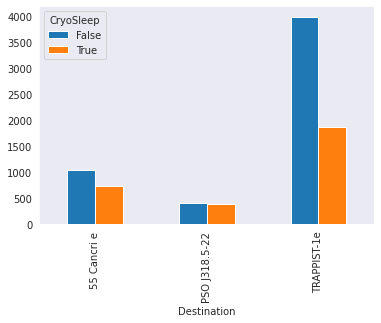

In [ ]:
tb = pd.crosstab(df.Destination, df.CryoSleep)
tb.plot(kind='bar')

In [ ]:
import random
probs = df.CryoSleep[df.Destination=='TRAPPIST-1e'].value_counts()/df.CryoSleep[df.Destination=='TRAPPIST-1e'].count()
df.CryoSleep = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.CryoSleep) and x.Destination=='TRAPPIST-1e' else x.CryoSleep,axis=1)

###Fill based on whether Transported or not

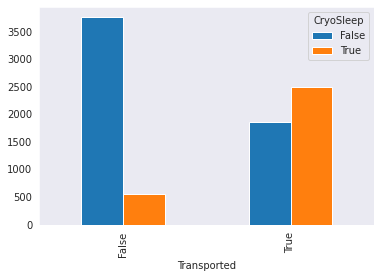

In [ ]:
tb = pd.crosstab(df.Transported, df.CryoSleep)
tb.plot(kind='bar')

In [ ]:
probs = df.CryoSleep[df.Transported == False].value_counts()/df.CryoSleep[df.Transported == False].count()
df.CryoSleep = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.CryoSleep) and x.Transported==False else x.CryoSleep,axis=1)

###Fill based on probability

In [ ]:
probs = df.VIP.value_counts()/df.VIP.count()
df.CryoSleep = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.CryoSleep) else x.CryoSleep,axis=1)



##3.   Cabin



In [ ]:
df.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
PG                0
dtype: int64

###Fill using PG since passengers from the same PG will have same cabin in most cases

In [ ]:
hpgrouped = df.groupby('PG')
c=hpgrouped.Cabin.nunique().value_counts()
c

1    5697
2     400
0      99
3      21
Name: Cabin, dtype: int64

In [ ]:
def fill(x):
  if not pd.isnull(x.Cabin):
    return x.Cabin
  v = df.Cabin[df.PG == x.PG].dropna().mode()
  if v.shape[0]>0:
    return v[0]
  return x.Cabin

df.Cabin = df.apply(fill,axis = 1)

###For the rest empty values, fill using proabilty

In [ ]:
probs = df.Cabin.value_counts()/ df.Cabin.count()
df.Cabin = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.Cabin) else x.Cabin, axis=1)



##4.   Destination



In [ ]:
df.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
PG                0
dtype: int64

In [ ]:
probs = df.Destination.value_counts()/ df.Destination.count()
df.Destination = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.Destination) else x.Destination, axis=1)



##5.   VIP



In [ ]:
probs = df.VIP.value_counts()/ df.VIP.count()
df.VIP = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.VIP) else x.VIP, axis=1)



#6.   Name



In [ ]:
probs = df.Name.value_counts()/ df.Name.count()
df.Name = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.Name) else x.Name, axis=1)



##7.   Numerical Features



In [ ]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PG
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Ofracculy,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Vines,True,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Susent,False,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Susent,False,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Santantines,True,0004


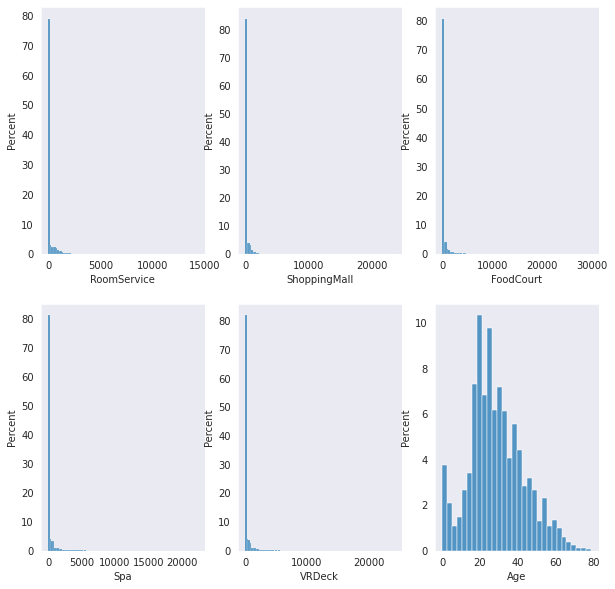

In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2, 3, 1)
sns.histplot(x=df.RoomService, bins=100, ax=ax1, stat='percent')

ax2 = fig.add_subplot(2, 3, 2)
sns.histplot(x=df.ShoppingMall, bins=100, ax=ax2, stat='percent')

ax3 = fig.add_subplot(2, 3, 3)
sns.histplot(x=df.FoodCourt, bins=100, ax=ax3, stat='percent')

ax4 = fig.add_subplot(2, 3, 4)
sns.histplot(x=df.Spa, bins=100, ax=ax4, stat='percent')

ax5 = fig.add_subplot(2, 3, 5)
sns.histplot(x=df.VRDeck, bins=100, ax=ax5, stat='percent')

ax6 = fig.add_subplot(2, 3, 6)
sns.histplot(x=df.Age, bins=30, ax=ax6, stat='percent')

plt.show()

###If CryoSleep is true than amenities bill will be zero

In [ ]:
def fill(x):
  if x.CryoSleep == True:
    if pd.isnull(x.RoomService):
      x.RoomService = 0
    if pd.isnull(x.ShoppingMall):
      x.ShoppingMall = 0
    if pd.isnull(x.FoodCourt):
      x.FoodCourt = 0
    if pd.isnull(x.Spa):
      x.Spa = 0
    if pd.isnull(x.VRDeck):
      x.VRDeck = 0
  return x
df = df.apply(fill, axis = 1)
df.isna().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age             179
VIP               0
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Name              0
Transported       0
PG                0
dtype: int64

###Check for the rest of the empty values whether to use mean or median

In [ ]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
  print(col, "mean - ",df[col].mean(), "median - ", df[col].median())

Age mean -  28.82793046746535 median -  27.0
RoomService mean -  222.90687645687646 median -  0.0
FoodCourt mean -  454.3399766899767 median -  0.0
ShoppingMall mean -  171.7855727770656 median -  0.0
Spa mean -  308.7802915451895 median -  0.0
VRDeck mean -  302.64853507645614 median -  0.0


###For amenities fill with median and for Age fill with mean

In [ ]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
  if col=='Age':
    df[col] = df[col].fillna(df[col].mean())
  else:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
df.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
PG              0
dtype: int64

#Feature Engineering

##Plot Transported vs the categorical features

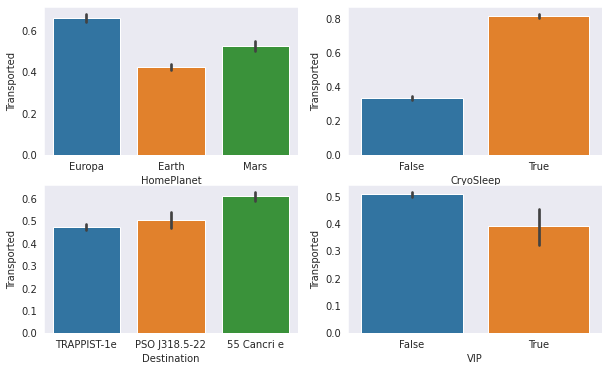

In [ ]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(2, 2, 1)
sns.barplot(x=df.HomePlanet, y=df.Transported, ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
sns.barplot(x=df.CryoSleep, y=df.Transported, ax=ax2)

ax3 = fig.add_subplot(2, 2, 3)
sns.barplot(x=df.Destination, y=df.Transported, ax=ax3)

ax4 = fig.add_subplot(2, 2, 4)
sns.barplot(x=df.VIP, y=df.Transported, ax=ax4)

plt.show()

### Split the Cabin feature to create new features since Cabin has so many categories

In [ ]:
df["Cabin_deck"] = df.Cabin.str.split("/").str[0]
df["Cabin_num"] = df.Cabin.str.split('/').str[1]
df["Cabin_side"] = df.Cabin.str.split('/').str[2]

###Create a feature for number of people in Cabin

In [ ]:
df["people_in_cabin"] = df.Cabin.map(df.Cabin.value_counts())

###Plot Cabin related information

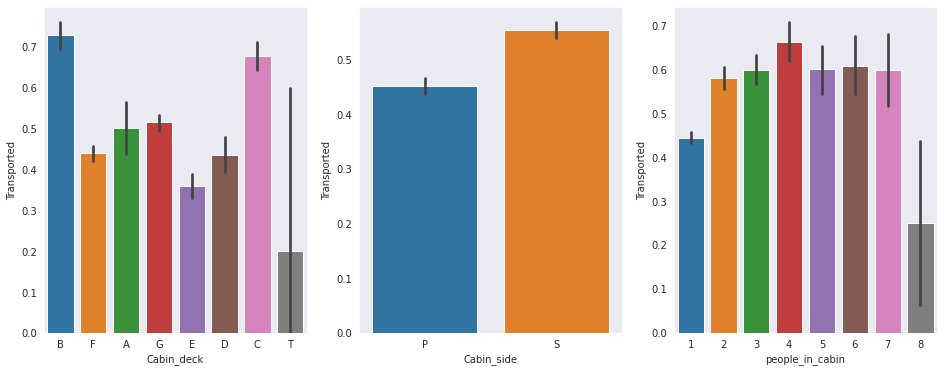

In [ ]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1, 3, 1)
sns.barplot(x=df.Cabin_deck, y=df.Transported, ax=ax1)

ax2 = fig.add_subplot(1, 3, 2)
sns.barplot(x=df.Cabin_side, y=df.Transported, ax=ax2)

ax3 = fig.add_subplot(1, 3, 3)
sns.barplot(x=df.people_in_cabin, y=df.Transported, ax=ax3)

plt.show()

###Feature engineer the Age feature

In [ ]:
df.Transported.corr(df.Age)

-0.07424911053933292

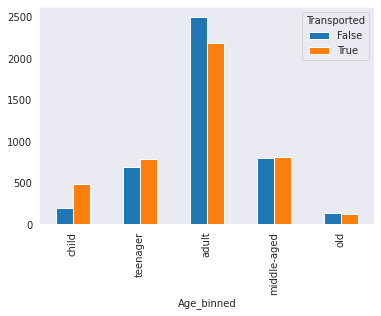

In [ ]:
bins = [0, 10, 20, 40, 60, 80]
labels = ["child", "teenager", "adult", "middle-aged", "old"]
df["Age_binned"] = pd.cut(df.Age, bins, labels=labels, right=False)
pd.crosstab(df.Age_binned, df.Transported).plot(kind='bar')

###Combine the family name and PG to create a family group feature

In [ ]:
df["g_fam"] = df.Name + '_' + df.PG

###Create no of members in a family using the Family name and family group feature

In [ ]:
df['no_of_mem1'] = df.Name.map(df.Name.value_counts(normalize=False))
df['no_of_mem2'] = df.g_fam.map(df.g_fam.value_counts(normalize=False))
df['people_in_group'] = df.PG.map(df.PG.value_counts(normalize=False))

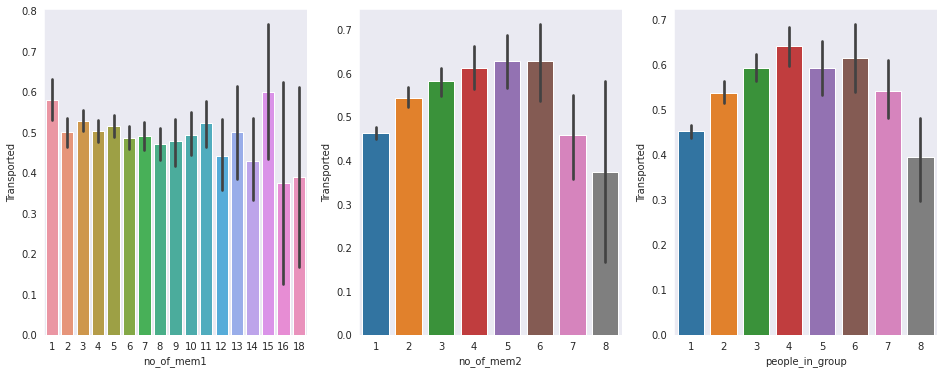

In [ ]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(1, 3, 1)
sns.barplot(x=df.no_of_mem1, y=df.Transported, ax=ax1)

ax2 = fig.add_subplot(1, 3, 2)
sns.barplot(x=df.no_of_mem2, y=df.Transported, ax=ax2)

ax3 = fig.add_subplot(1, 3, 3)
sns.barplot(x=df.people_in_group, y=df.Transported, ax=ax3)

plt.show()

###Combining the amenities features

In [ ]:
df["shop_bill"] = df.FoodCourt + df.ShoppingMall
df["othr_srvc_bill"] = df.RoomService + df.Spa + df.VRDeck
df["total_bill"] = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck

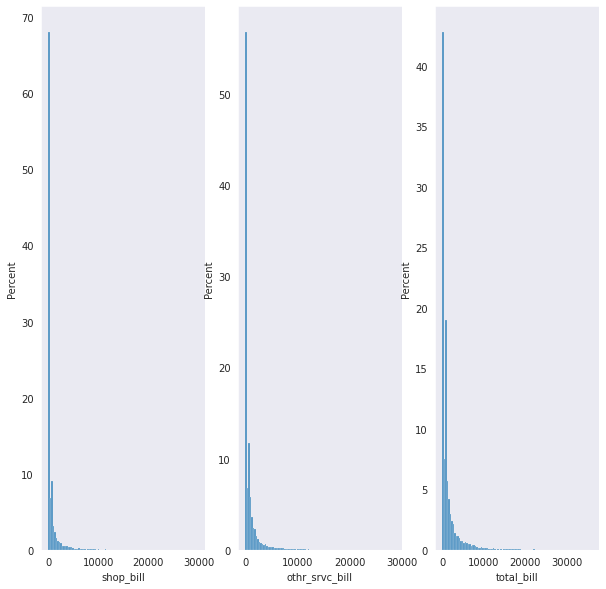

In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(1, 3, 1)
sns.histplot(x=df.shop_bill, bins=100, ax=ax1, stat='percent')

ax2 = fig.add_subplot(1, 3, 2)
sns.histplot(x=df.othr_srvc_bill, bins=100, ax=ax2, stat='percent')

ax3 = fig.add_subplot(1, 3, 3)
sns.histplot(x=df.total_bill, bins=100, ax=ax3, stat='percent')

plt.show()

###Lets normalize the numerical columns

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler, MaxAbsScaler

scaler = MinMaxScaler()

for col in df.select_dtypes(include=['float64', 'int64']).columns:
  df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

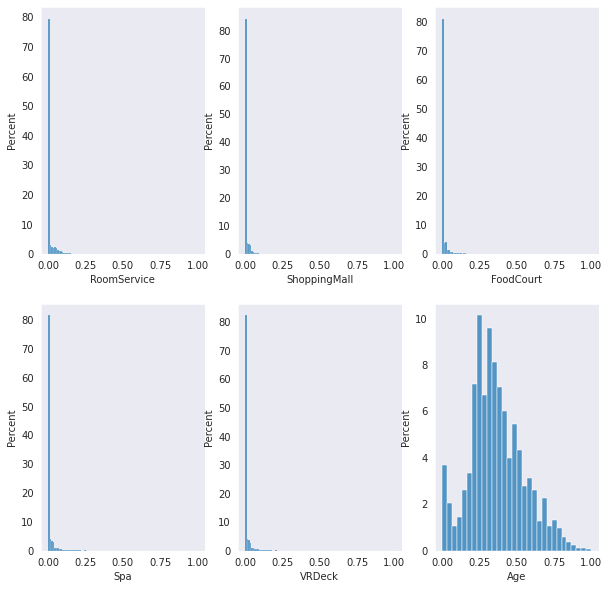

In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2, 3, 1)
sns.histplot(x=df.RoomService, bins=100, ax=ax1, stat='percent')

ax2 = fig.add_subplot(2, 3, 2)
sns.histplot(x=df.ShoppingMall, bins=100, ax=ax2, stat='percent')

ax3 = fig.add_subplot(2, 3, 3)
sns.histplot(x=df.FoodCourt, bins=100, ax=ax3, stat='percent')

ax4 = fig.add_subplot(2, 3, 4)
sns.histplot(x=df.Spa, bins=100, ax=ax4, stat='percent')

ax5 = fig.add_subplot(2, 3, 5)
sns.histplot(x=df.VRDeck, bins=100, ax=ax5, stat='percent')

ax6 = fig.add_subplot(2, 3, 6)
sns.histplot(x=df.Age, bins=30, ax=ax6, stat='percent')

plt.show()

In [ ]:
df.describe(include='object')

,PassengerId,HomePlanet,Cabin,Destination,Name,PG,Cabin_deck,Cabin_num,Cabin_side,g_fam
count,8693,8693,8693,8693,8693,8693,8693,8693,8693,8693
unique,8693,3,6560,3,2217,6217,8,1817,2,6587
top,0001_01,Earth,G/734/S,TRAPPIST-1e,Casonston,4498,F,82,S,Oneiles_5885
freq,1,4710,8,6053,18,8,2843,28,4393,8


###PassengerId, Cabin, Name, PG, Cabin_num and g_fam are not that usefull. Drop them

In [ ]:
df = df.drop(columns=['PassengerId', 'Cabin', 'Name', 'PG', 'Cabin_num', 'g_fam'])

In [ ]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_deck,Cabin_side,people_in_cabin,Age_binned,no_of_mem1,no_of_mem2,people_in_group,shop_bill,othr_srvc_bill,total_bill
0,Europa,False,TRAPPIST-1e,0.493671,False,0.000000,0.000000,0.000000,0.000000,0.000000,...,B,P,0.000000,adult,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Earth,False,TRAPPIST-1e,0.303797,False,0.007608,0.000302,0.001064,0.024500,0.001823,...,F,S,0.000000,adult,0.176471,0.000000,0.000000,0.001140,0.024545,0.020452
2,Europa,False,TRAPPIST-1e,0.734177,True,0.003001,0.119948,0.000000,0.299670,0.002030,...,A,S,0.142857,middle-aged,0.294118,0.142857,0.142857,0.119948,0.238007,0.288521
3,Europa,False,TRAPPIST-1e,0.417722,False,0.000000,0.043035,0.015793,0.148563,0.007997,...,A,S,0.142857,adult,0.294118,0.142857,0.142857,0.055479,0.123147,0.143830
4,Earth,False,TRAPPIST-1e,0.202532,False,0.021149,0.002348,0.006428,0.025214,0.000083,...,F,S,0.000000,teenager,0.294118,0.000000,0.000000,0.007413,0.030420,0.030317


# Create a function to do all the above transformation

In [ ]:
from pandas.io.formats.info import DataFrameInfoPrinter
def fix_missing_data(df: pd.DataFrame, dft='train')->pd.DataFrame:
  import random
  
  df["Name"] = df.Name.str.split().str[-1]
  df['PG'] = df.PassengerId.str.split('_').str[0]

  ## HomePlanet
  probs = df.HomePlanet.value_counts()/ df.HomePlanet.count()
  def fill_HomePlanet(x):
    if not pd.isnull(x.HomePlanet):
      return x.HomePlanet

    v1 = df.HomePlanet[df.PG==x.PG].dropna().mode()
    if v1.shape[0]>0:
      return v1[0]

    v2 = df.HomePlanet[df.Name==x.Name].dropna().mode()
    if v2.shape[0]>0:
      return v2[0] 
    return random.choices(probs.keys(), probs.values)[0]
  df.HomePlanet = df.apply(fill_HomePlanet, axis=1)

  ## CryoSleep
  probs = df.CryoSleep.value_counts()/ df.CryoSleep.count()
  if dft=='train':
    p_tr = df.CryoSleep[df.Transported == False].value_counts()/df.CryoSleep[df.Transported == False].count()
  p_dest = df.CryoSleep[df.Destination=='TRAPPIST-1e'].value_counts()/df.CryoSleep[df.Destination=='TRAPPIST-1e'].count()
  def fill_CryoSleep(x):
    if not pd.isnull(x.CryoSleep):
      return x.CryoSleep
    
    if any((x.VRDeck, x.ShoppingMall, x.RoomService, x.FoodCourt, x.Spa))>0:
      return False
    if dft == 'train' and x.Transported == False:
      return random.choices(p_tr.keys(), p_tr.values)[0]
    if x.Destination == 'TRAPPIST-1e':
      return random.choices(p_dest.keys(), p_dest.values)[0]
    
    return random.choices(probs.keys(), probs.values)[0]
  df.CryoSleep = df.apply(fill_CryoSleep, axis=1)

  ## Cabin
  probs = df.Cabin.value_counts()/ df.Cabin.count()
  def fill_Cabin(x):
    if not pd.isnull(x.Cabin):
      return x.Cabin
    v = df.Cabin[df.PG == x.PG].dropna().mode()
    if v.shape[0]>0:
      return v[0]
    return random.choices(probs.keys(), probs.values)[0]
  df.Cabin = df.apply(fill_Cabin, axis=1)
    
  ## Destination
  probs = df.Destination.value_counts()/ df.Destination.count()
  df.Destination = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.Destination) else x.Destination, axis=1)

  ## VIP
  probs = df.VIP.value_counts()/ df.VIP.count()
  df.VIP = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.VIP) else x.VIP, axis=1)

  ## Name
  probs = df.Name.value_counts()/ df.Name.count()
  df.Name = df.apply(lambda x: random.choices(probs.keys(), probs.values)[0] if pd.isnull(x.Name) else x.Name, axis=1)

  ## Numerical Columns
  def fill_using_cryoSleep(x):
    if x.CryoSleep == True:
      if pd.isnull(x.RoomService):
        x.RoomService = 0
      if pd.isnull(x.ShoppingMall):
        x.ShoppingMall = 0
      if pd.isnull(x.FoodCourt):
        x.FoodCourt = 0
      if pd.isnull(x.Spa):
        x.Spa = 0
      if pd.isnull(x.VRDeck):
        x.VRDeck = 0
    return x
  df = df.apply(fill_using_cryoSleep, axis = 1)

  ## Using mean for Age and median for others
  for col in df.select_dtypes(include=['float64', 'int64']).columns:
    if col=='Age':
      df[col] = df[col].fillna(df[col].mean())
    else:
      df[col] = df[col].fillna(df[col].median())
  
  return df

def create_features(df: pd.DataFrame)->pd.DataFrame:
  ## Creating new features
  bins = [0, 10, 20, 40, 60, 80]
  labels = ["child", "teenager", "adult", "middle-aged", "old"]
  df["Age_binned"] = pd.cut(df.Age, bins, labels=labels, right=False)

  df["Cabin_deck"] = df.Cabin.str.split("/").str[0]
  df["Cabin_num"] = df.Cabin.str.split('/').str[1]
  df["Cabin_side"] = df.Cabin.str.split('/').str[2]
  df["people_in_cabin"] = df.Cabin.map(df.Cabin.value_counts())
  df['people_in_group'] = df.PG.map(df.PG.value_counts(normalize=False))

  df["g_fam"] = df.Name + '_' + df.PG
  df['no_of_mem1'] = df.Name.map(df.Name.value_counts(normalize=False))
  df['no_of_mem2'] = df.g_fam.map(df.g_fam.value_counts(normalize=False))

  df["shop_bill"] = df.FoodCourt + df.ShoppingMall
  df["othr_srvc_bill"] = df.RoomService + df.Spa + df.VRDeck
  df["total_bill"] = df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck

  return df

def normalize(df: pd.DataFrame)->pd.DataFrame:
  from sklearn.preprocessing import MinMaxScaler, RobustScaler

  scaler = MinMaxScaler()

  for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

  return df

def drop_features(df: pd.DataFrame)->pd.DataFrame:
  df = df.drop(columns=['PassengerId', 'Cabin', 'Name', 'PG', 'Cabin_num', 'g_fam'])
  return df

def encode_categorical_columns(df: pd.DataFrame)->pd.DataFrame:
  ## Encode categorical columns
  categorical_cols = df.select_dtypes(include = ['object', 'category'])

  from sklearn.compose import ColumnTransformer
  from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

  encoder = OrdinalEncoder()
  df[categorical_cols.columns] = encoder.fit_transform(categorical_cols)

  return df

def pipeline(dataframe: pd.DataFrame, dft='train')->pd.DataFrame:
  df = dataframe[:]
  df = fix_missing_data(df, dft)
  df = create_features(df)
  #df = normalize(df)
  df = drop_features(df)
  df = encode_categorical_columns(df)
  return df
  

#Model Selection

In [ ]:
train_df = pipeline(pd.read_csv("train.csv"))
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.describe()

,HomePlanet,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age_binned,Cabin_deck,Cabin_side,people_in_cabin,people_in_group,no_of_mem1,no_of_mem2,shop_bill,othr_srvc_bill,total_bill
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.666053,1.483838,0.107525,5.366081,7.351377,7.707832,5.746960,7.456545,1.215576,4.296330,0.504889,0.862073,0.517773,0.147015,0.775336,1.028344,0.900778,0.503030
std,0.798897,0.820174,0.843474,16.110221,26.160502,27.182144,21.237029,28.353160,1.524611,1.783129,0.500005,1.436716,0.798173,0.751321,1.269407,2.827435,2.159095,1.945209
min,0.000000,0.000000,-1.588235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-0.001667,-0.069575,-0.496877
25%,0.000000,1.000000,-0.411765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,-0.500000,0.000000,-0.001667,-0.069575,-0.496877
50%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.588235,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,6.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.998333,0.930425,0.503123
max,2.000000,2.000000,3.058824,349.439024,488.737705,1067.818182,422.792453,603.325000,4.000000,7.000000,1.000000,8.000000,3.500000,3.250000,7.000000,49.686667,33.656840,24.476752


In [ ]:
X_train = train_df.drop('Transported', axis=1)
y_train = train_df.Transported

X_test = pipeline(test_df, dft='test')

In [ ]:
X_test.describe()

,HomePlanet,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age_binned,Cabin_deck,Cabin_side,people_in_cabin,people_in_group,no_of_mem1,no_of_mem2,shop_bill,othr_srvc_bill,total_bill
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000
mean,0.682020,1.503858,0.097538,4.480467,6.493822,6.416041,6.881301,9.835429,1.226327,4.349778,0.501052,0.808978,0.997428,0.225703,0.734159,0.989828,0.907651,0.487314
std,0.812028,0.808512,0.825140,12.539885,22.881151,20.555251,25.694698,39.870704,1.542728,1.724387,0.500057,1.369258,1.537113,0.754935,1.155855,2.672832,2.169728,1.950417
min,0.000000,0.000000,-1.588235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.666667,0.000000,-0.001647,-0.044341,-0.494460
25%,0.000000,1.000000,-0.411765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,-0.333333,0.000000,-0.001647,-0.044341,-0.494460
50%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.588235,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,6.000000,1.000000,1.000000,1.000000,0.666667,1.000000,0.998353,0.955659,0.505540
max,2.000000,2.000000,3.058824,240.979167,382.924242,307.111111,461.488372,718.451613,4.000000,7.000000,1.000000,8.000000,7.000000,3.666667,7.000000,41.634267,25.943991,22.819945


##Select best features

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=13)
selector.fit(X_train, y_train)

kbest = selector.get_feature_names_out()
kbest

array(['HomePlanet', 'CryoSleep', 'Destination', 'RoomService', 'Spa',
       'VRDeck', 'Cabin_deck', 'Cabin_side', 'people_in_cabin',
       'people_in_group', 'no_of_mem2', 'othr_srvc_bill', 'total_bill'],
      dtype=object)

In [ ]:
X_train = X_train[kbest]
X_test = X_test[kbest]

In [ ]:
!pip install sklearn-deap >> /dev/null

##Find the hyperparameters using EvolutionaryAlgorithmSearchCV

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.model_selection import StratifiedKFold

classifiers = {
    'SVM': (SVC(), {'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 1.0, 10.0]}),
    'Decision Tree': (DecisionTreeClassifier(), {'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [10, 20, 50, 100], 'max_depth': [2, 3, 4, 5]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'learning_rate': [0.1, 0.05, 0.01], 'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5],
                                                       'min_samples_split': [2, 3, 4],'min_samples_leaf': [1, 2, 3]})
}

for name, (clf, params) in classifiers.items():
  optimizer = EvolutionaryAlgorithmSearchCV( estimator=clf,
                                   params=params,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
  optimizer.fit(X_train, y_train)
  
  print(name)




Types [1, 2] and maxint [1, 3] detected


/usr/local/lib/python3.8/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.8/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


--- Evolve in 8 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	50    	0.735049	0.668699	0.774876	0.0281107
1  	39    	0.755631	0.7215  	0.774876	0.019245 
2  	34    	0.769888	0.730243	0.774876	0.00880408
3  	33    	0.774494	0.765328	0.774876	0.001871  
4  	35    	0.77229 	0.7215  	0.774876	0.010837  
5  	27    	0.773823	0.72219 	0.774876	0.00737605
Best individual is: {'kernel': 'linear', 'C': 10.0}
with fitness: 0.7748763372828713
SVM
Types [1, 1] and maxint [1, 3] detected


/usr/local/lib/python3.8/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.8/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


--- Evolve in 8 possible combinations ---
gen	nevals	avg     	min     	max     	std       
0  	50    	0.776038	0.766709	0.784884	0.00582551
1  	29    	0.780571	0.766709	0.784884	0.00381884
2  	31    	0.782869	0.766709	0.784884	0.00321714
3  	32    	0.784588	0.778672	0.784884	0.00111651
4  	29    	0.784859	0.783619	0.784884	0.000177154
5  	32    	0.784884	0.784884	0.784884	0          
Best individual is: {'criterion': 'gini', 'max_depth': 4}
with fitness: 0.7848843897388703
Decision Tree
Types [1, 1] and maxint [3, 3] detected


/usr/local/lib/python3.8/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.8/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


--- Evolve in 16 possible combinations ---
gen	nevals	avg     	min     	max    	std      
0  	50    	0.765257	0.739446	0.78569	0.0128943
1  	31    	0.774152	0.739676	0.78569	0.0095652
2  	24    	0.779452	0.760727	0.78569	0.00524637
3  	36    	0.781847	0.772806	0.784999	0.0020237 
4  	30    	0.782565	0.779593	0.785575	0.00140839
5  	30    	0.782568	0.778903	0.785575	0.00152143
Best individual is: {'n_estimators': 50, 'max_depth': 5}
with fitness: 0.7856896353387783
Random Forest
Types [2, 1, 1, 1, 1] and maxint [2, 2, 2, 2, 2] detected


/usr/local/lib/python3.8/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.8/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


--- Evolve in 243 possible combinations ---
gen	nevals	avg     	min     	max    	std      
0  	50    	0.796176	0.786955	0.80375	0.0048667
1  	34    	0.799211	0.790751	0.80398	0.0028031
2  	27    	0.801346	0.794547	0.80398	0.00188997
3  	37    	0.80239 	0.798228	0.80398	0.00151037
4  	32    	0.803288	0.800069	0.80398	0.000837307
5  	27    	0.803421	0.797653	0.804095	0.00144944 
Best individual is: {'learning_rate': 0.05, 'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}
with fitness: 0.8039802139652594
Gradient Boosting


##Check performance of each model

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

params = {'kernel': 'linear', 'C': 10.0}
svc = SVC(**params)
svc_cv_scores = cross_val_score(svc, X_train, y_train, cv=10)
svc_cv_scores.mean()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
params = {'criterion': 'gini', 'max_depth': 4}
dtc = DecisionTreeClassifier(**params)
dtc_cv_scores = cross_val_score(dtc, X_train, y_train, cv=10)
dtc_cv_scores.mean()

0.7853497877068369

In [ ]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': 50, 'max_depth': 5}
rfc = RandomForestClassifier(**params)
rfc_cv_scores = cross_val_score(rfc, X_train, y_train, cv=10)
rfc_cv_scores.mean()

0.784543073687552

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
params = {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}
gbc = GradientBoostingClassifier(**params)
gbc_cv_scores = cross_val_score(gbc, X_train, y_train, cv=10)
gbc_cv_scores.mean()

0.8046770630795074

In [ ]:
import xgboost as xgb
params = {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}
xgbc = xgb.XGBClassifier(**params)
xgbc_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=10)
xgbc_cv_scores.mean()

0.8050220229355978

In [ ]:
plt.boxplot([svc_cv_scores, dtc_cv_scores, rfc_cv_scores, gbc_cv_scores, xgbc_cv_scores], labels=["SVM", "DTC", "RFC", "GBC", "XGBC"])
plt.xlabel("Model Name")
plt.ylabel("CV Score")
plt.show()

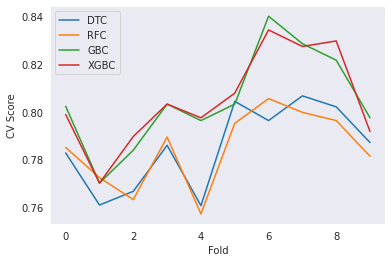

In [ ]:
plt.plot(svc_cv_scores, label="SVM")
plt.plot(dtc_cv_scores, label="DTC")
plt.plot(rfc_cv_scores, label="RFC")
plt.plot(gbc_cv_scores, label="GBC")
plt.plot(xgbc_cv_scores, label="XGBC")
plt.xlabel("Fold")
plt.ylabel("CV Score")
plt.legend()
plt.show()

In [ ]:
model = gbc

In [ ]:
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_leaf=2,
                           n_estimators=500)

In [ ]:
test_df['Transported'] = model.predict(X_test)

In [ ]:
test_df[['PassengerId', 'Transported']].to_csv("submission_rudra.csv", index=False)

In [ ]:
!kaggle competitions submit -c spaceship-titanic -f submission_rudra.csv -m ""

100% 56.4k/56.4k [00:00<00:00, 99.0kB/s]
Successfully submitted to Spaceship Titanic

In [ ]:
!pip install tpot >> /dev/null

In [ ]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, cv=5)
tpot.fit(X_train, y_train)

print("Best hyperparameters:", tpot.fitted_pipeline_)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8028318723443959

Generation 2 - Current best internal CV score: 0.8028318723443959

Generation 3 - Current best internal CV score: 0.8028318723443959

Generation 4 - Current best internal CV score: 0.8051319786843623

Generation 5 - Current best internal CV score: 0.8051319786843623

Best pipeline: XGBClassifier(SGDClassifier(input_matrix, alpha=0.0, eta0=0.1, fit_intercept=True, l1_ratio=0.0, learning_rate=constant, loss=modified_huber, penalty=elasticnet, power_t=10.0), learning_rate=0.1, max_depth=7, min_child_weight=13, n_estimators=100, n_jobs=1, subsample=0.7000000000000001, verbosity=0)
Best hyperparameters: Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=SGDClassifier(alpha=0.0, eta0=0.1,
                                                           l1_ratio=0.0,
                                                           learning_rate='constant',
                                                  